Using BDTs with weights

In [1]:
from glob import glob
import sys, scipy, pickle
from scipy.stats import chi2, poisson
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

from prettytable import PrettyTable

In [2]:
import ROOT as rt
import root_numpy as rtnp
from utility_func import *

Welcome to JupyROOT 6.12/06


Using TensorFlow backend.


In [3]:
import sklearn
print sklearn.__version__
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.externals import joblib

0.20.3


In [4]:
do_training = 0

# Get the samples

In [5]:
hlf_features = ['HT', 'METp', 'METo', 'MT', 'nJets', 
                'bJets', 'allJetMass', 'LepPt', 'LepEta', 
                'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 
                'LepIsEle', 'nMu', 'allMuMass', 'allMuPt', 'nEle', 
                'allEleMass', 'allElePt', 'nChHad', 'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'allJetMass',
                       'allMuPt', 'allMuMass',
                       'allElePt','allEleMass',
                       'LepPt', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'METp', 'METo',
                       
                       'MT',
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 
                       
                       'LepCharge','LepIsEle', 
                       
                       'nChHad', 'nNeuHad']

Nf_lognorm = 10
Nf_gauss = 2
Nf_Pgauss = 1
Nf_PDgauss = 4
Nf_binomial = 2
Nf_poisson = 2

sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)
# print 'Activated HLF:'
# for n in np.array(hlf_features)[sel]:
#     print '\t', n

In [6]:
data_folder = '../data/HLF_ONLY/'
TrainSamplesName = ['Wlnu', 'qcd', 'Zll', 'ttbar']
BSM_samples = ['Ato4l', 'leptoquark', 'hToTauTau', 'hChToTauNu', 'Zprime', 'Wprime']

N_train_max = int(6e6)
training_split_fraction = 0.5

In [7]:
fraction = np.array([0.592, 0.338, 0.067, 0.003])

raw_sample = {}
l = np.zeros(4)
for i,n in enumerate(TrainSamplesName):
    raw_sample[n] = np.load(data_folder+n+'_sample.npy')
#     np.random.shuffle(raw_sample[n])
    l[i] = raw_sample[n].shape[0]
    
i_min = np.argmin(l/fraction)
if TrainSamplesName[i_min]=='qcd':
    print 'QCD is limiting, using it for both val and split'
    N_train = min(N_train_max, l[i_min]/fraction[i_min])
else:
    N_train = min(N_train_max, training_split_fraction*l[i_min]/fraction[i_min])
    
if N_train < N_train_max:
    print 'Limiting stat. sample:', TrainSamplesName[i_min]
else:
    print 'Sample available satisfying '

N_val = N_train*(1-training_split_fraction)/training_split_fraction - 1
print 'Expected {:.2f} train'.format(N_train/1.0e6)
print 'Expected {:.2f} val'.format(N_val/1.0e6)

QCD is limiting, using it for both val and split
Limiting stat. sample: qcd
Expected 3.45 train
Expected 3.45 val


In [8]:
x_train_s = {}
x_val_s = {}

table = PrettyTable(['Sample', 'Evts tot', 'Train', 'Val'])

for i,n in enumerate(TrainSamplesName):
    N_train_aux = int(N_train * fraction[i])
    x_train_s[n] = raw_sample[n][:N_train_aux, sel]
    N_val_aux = int(N_val * fraction[i])
    if TrainSamplesName[i_min]=='qcd' and n == 'qcd':
        print 'QCD is limiting, using it for both val and split'
        np.random.shuffle(raw_sample[n])
        x_val_s[n] = raw_sample[n][:N_val_aux, sel]
    elif N_train_aux+N_val_aux < raw_sample[n].shape[0]:
        x_val_s[n] = raw_sample[n][N_train_aux : N_train_aux+N_val_aux, sel]
    else:
        print 'Error', n
        continue
    table.add_row([n, raw_sample[n].shape[0], x_train_s[n].shape[0], x_val_s[n].shape[0]])
print table
    
x_train = np.concatenate((x_train_s['Wlnu'], x_train_s['qcd'], x_train_s['Zll'], x_train_s['ttbar']))
x_val = np.concatenate((x_val_s['Wlnu'], x_val_s['qcd'], x_val_s['Zll'], x_val_s['ttbar']))

print 'Tot training {:.2f} M'.format(x_train.shape[0]/1.0e6)
print 'Tot val {:.2f} M'.format(x_val.shape[0]/1.0e6)

QCD is limiting, using it for both val and split
+--------+----------+---------+---------+
| Sample | Evts tot |  Train  |   Val   |
+--------+----------+---------+---------+
|  Wlnu  | 8000082  | 2042566 | 2042565 |
|  qcd   | 1166195  | 1166195 | 1166194 |
|  Zll   | 1777383  |  231168 |  231168 |
| ttbar  | 5001726  |  10350  |  10350  |
+--------+----------+---------+---------+
Tot training 3.45 M
Tot val 3.45 M


In [9]:
x_sig_train = {}
x_sig_val = {}
weight_sig = {}
for n in BSM_samples:
    s = np.load(data_folder+n+'_sample.npy')
    N_aux = min(int(N_train_max/training_split_fraction), s.shape[0])
    N_train_aux = int(N_aux*training_split_fraction)
    N_val_aux = N_aux - N_train_aux
    x_sig_train[n] = s[:N_train_aux, sel]
    x_sig_val[n] = s[N_train_aux:N_train_aux+N_val_aux, sel]
    w = float(x_train.shape[0])/x_sig_train[n].shape[0]
    weight_sig[n] = w
    print '{} {:.3f}M ({:.1f})'.format(n, s.shape[0]*1.e-6, w)

Ato4l 0.652M (10.6)
leptoquark 0.583M (11.8)
hToTauTau 0.345M (20.0)
hChToTauNu 0.339M (20.4)
Zprime 0.055M (124.6)
Wprime 0.606M (11.4)


In [10]:
# def train_it(n):
#     bdt_clf[n] = GBC(loss='deviance',
#                      learning_rate=0.1,
#                      n_estimators=150,
#                      min_samples_leaf=3,
#                      max_depth=3,
# #                      max_features=int(x_train.shape[1]*0.5),
#                      n_iter_no_change=3,
#                      tol=0.0001,
#                      validation_fraction=0.2,
#                      verbose=1
#                     )

#     print '\n\n------------------ Training', n, '--------------------'
#     aux_x = np.concatenate(( x_train, x_sig_train[n]))
#     aux_y = np.concatenate(( np.zeros(x_train.shape[0]), np.ones(x_sig_train[n].shape[0]) ))
#     w     = np.concatenate(( np.ones(x_train.shape[0]), weight_sig[n]*np.ones(x_sig_train[n].shape[0]) ))

#     bdt_clf[n].fit(X=aux_x, y=aux_y, sample_weight=w)
#     joblib.dump(bdt_clf[n], 'Classifier_HLF_v4/Classifier_'+n+'_v4.pkl')    

# Start the Classifier declaration

In [11]:
bdt_clf = {}

### Do the training

In [12]:
for n in BSM_samples: 
    if do_training:
#         train_it(n)
        pass
    else:
        filename = ('Classifier_HLF_v4/Classifier_'+n+'_v4.pkl')
        bdt_clf[n] = joblib.load(filename) 

/Users/olmo/programs/miniconda2/lib/python2.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.0 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/olmo/programs/miniconda2/lib/python2.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.20.0 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [13]:
Eff_SM = 5.38e-06

In [14]:
def ROC_curve(p_BSM, p_SM, eval_q_SM):
    eval_p = np.percentile(1-p_SM, q=100*eval_q_SM)
    
    out = (1-p_BSM) < np.atleast_2d(eval_p).T
    out = np.sum(out, axis=1)
    q_BSM = out/float(p_BSM.shape[0])
    
    AUC = np.trapz(q_BSM, eval_q_SM)
    
    return q_BSM, AUC

Ato4l: 6.13e-06
leptoquark: 2.26e-04
hToTauTau: 5.68e-04
hChToTauNu: 3.10e-03


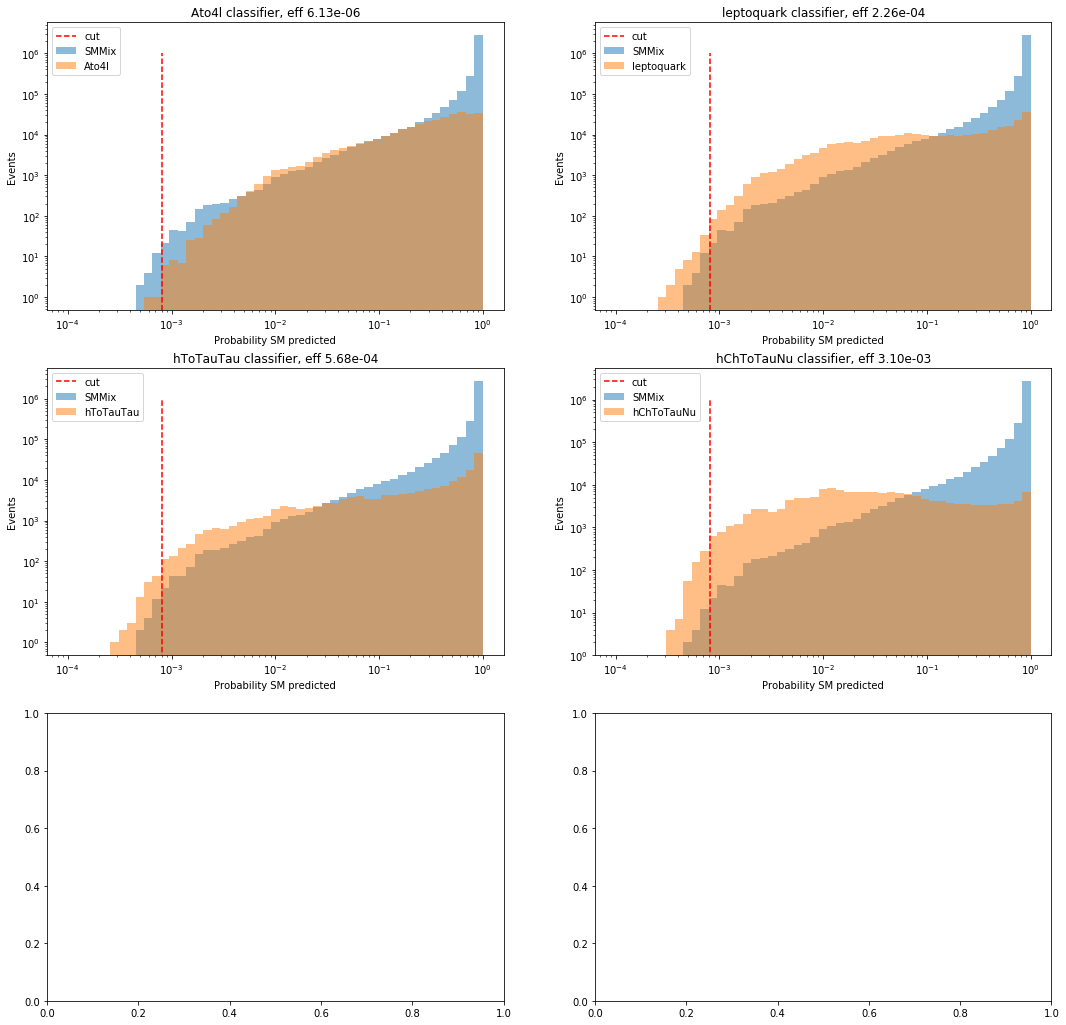

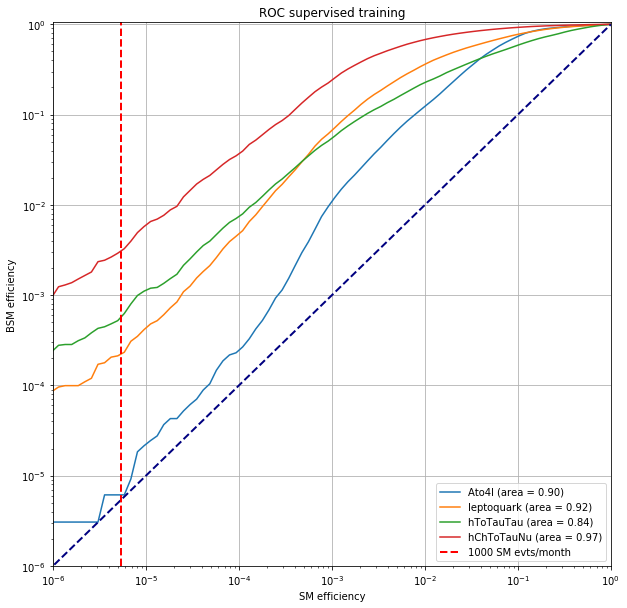

In [19]:
f, ax_arr = plt.subplots(3,2 , figsize=(18,18))

f_ROC, ax_arr_ROC = plt.subplots(1,1, figsize=(10,10))

clfToUse = 'hChToTauNu'

for i,n in enumerate(BSM_samples[:-2]):
    p_SM = bdt_clf[clfToUse].predict_proba(x_val)[:,1]
    p_BSM = bdt_clf[clfToUse].predict_proba(x_sig_val[n])[:,1]
    
    # print ROC curve
    q_SM = np.logspace(base=10, start=-7, stop=0, num=100)
    q_BSM, roc_auc = ROC_curve(p_BSM, p_SM, q_SM)
    dic2save = {'eff_BSM':q_BSM, 'eff_SM':q_SM, 'roc_auc':roc_auc}
    fileout = open('Classifier_HLF_v4/ROC_dict_{}_wCLF{}.pkl'.format(n, clfToUse), 'w')
    pickle.dump(file=fileout, obj=dic2save)
    fileout.close()
    ax_arr_ROC.plot(q_SM, q_BSM, label='{} (area = {:0.2f})'.format(n, roc_auc))
    
    

    q = np.percentile(p_SM, 100*(1-Eff_SM))
    eff_BSM = float(np.sum(p_BSM>q))/x_sig_val[n].shape[0]

    print '{}: {:1.2e}'.format(n, eff_BSM)
    
    bins = np.logspace(base=10, start=-4, stop=0, num=50)
    if n=='Wprime':
        bins = np.logspace(base=10, start=-2, stop=0, num=50)
    ax_arr[i/2,i%2].hist(1-p_SM, bins=bins, alpha = 0.5, label='SMMix')
    ax_arr[i/2,i%2].hist(1-p_BSM, bins=bins, alpha=0.5, label=n)
    ax_arr[i/2,i%2].plot([1-q,1-q], [0,1e6], '--r', label='cut')

    ax_arr[i/2,i%2].set_title('{} classifier, eff {:1.2e}'.format(n, eff_BSM))
    ax_arr[i/2,i%2].legend(loc='best')
    ax_arr[i/2,i%2].set_ylabel('Events')
    ax_arr[i/2,i%2].set_xlabel('Probability SM predicted')
    ax_arr[i/2,i%2].set_yscale('log')
    ax_arr[i/2,i%2].set_xscale('log')
    
ax_arr_ROC.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax_arr_ROC.plot([Eff_SM, Eff_SM], [1e-6, 1.05], color='red', lw=2, linestyle='--', label='1000 SM evts/month')
ax_arr_ROC.set_xlim([1e-6, 1.0])
ax_arr_ROC.set_ylim([1e-6, 1.05])
ax_arr_ROC.set_xlabel('SM efficiency')
ax_arr_ROC.set_ylabel('BSM efficiency')
ax_arr_ROC.set_title('ROC supervised training')
ax_arr_ROC.legend(loc="lower right")
ax_arr_ROC.set_yscale('log')
ax_arr_ROC.set_xscale('log')
ax_arr_ROC.grid()
f_ROC.savefig('Classifier_HLF_v4/ROC_clf_wCFL{}.png'.format(clfToUse))